### Golden cross
#### Cumulative Returns for SMA and Buy and Hold Strategy

In [5]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

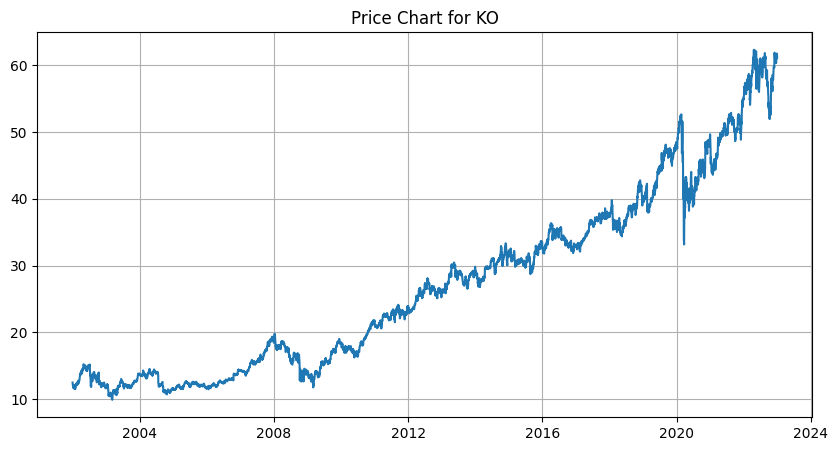

In [19]:
ticker = "KO"
yfObj = yf.Ticker(ticker)
data = yfObj.history(start="2002-01-01", end="2022-12-31")
plt.figure(figsize=(10, 5))
plt.plot(data['Close'])
plt.title(f'Price Chart for {ticker}')
plt.grid()
plt.show()

In [20]:
def SMABacktest(ticker, short_term_sma, long_term_sma,
    shorts=False, start_date='2000-01-01', end_date='2022-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)

    data['SMA1'] = data['Close'].rolling(short_term_sma).mean()
    data['SMA2'] = data['Close'].rolling(long_term_sma).mean()
    if shorts:
        data['position'] = np.where(
            data['SMA1'] > data['SMA2'], 1, -1)
    else:
        data['position'] = np.where(
            data['SMA1'] > data['SMA2'], 1, 0)

    # Calculate returns
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) *  data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns'] = np.exp(
        data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()

    return data


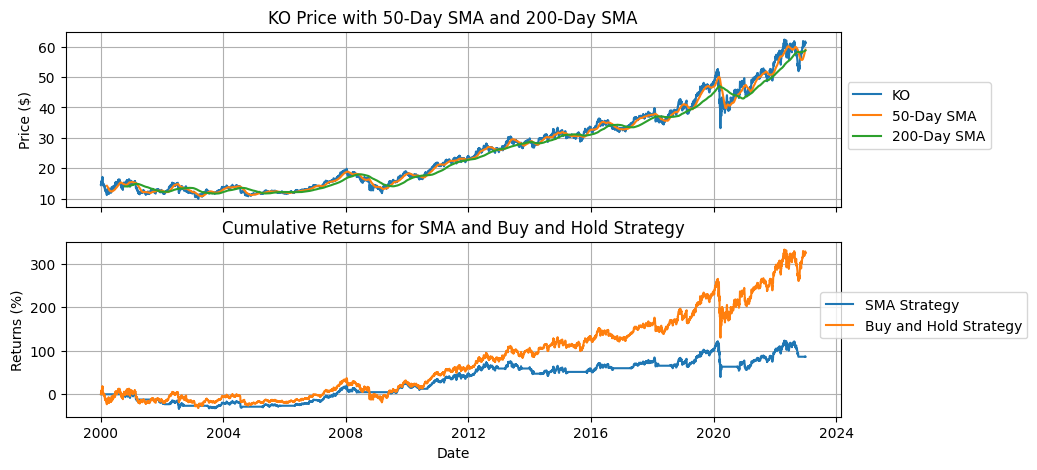

In [21]:
short_term_sma = 50
long_term_sma = 200
data = SMABacktest(ticker, short_term_sma, long_term_sma)
fig, ax = plt.subplots(2, figsize=(10, 5), sharex=True)
ax[0].plot(data['Close'], label=ticker)
ax[0].plot(data['SMA1'], label=f"{short_term_sma}-Day SMA")
ax[0].plot(data['SMA2'], label=f"{long_term_sma}-Day SMA")
ax[0].set_ylabel('Price ($)')
ax[0].set_title(f'{ticker} Price with {short_term_sma}-Day SMA and {long_term_sma}-Day SMA')
ax[0].legend(bbox_to_anchor=[1, 0.75])
ax[0].grid()
ax[1].plot((data['strat_cum_returns'] - 1) * 100, label='SMA Strategy')
ax[1].plot((data['cum_returns'] - 1) * 100, label='Buy and Hold Strategy')
ax[1].set_ylabel('Returns (%)')
ax[1].set_xlabel('Date')
ax[1].set_title(f'Cumulative Returns for SMA and Buy and Hold Strategy')
ax[1].legend(bbox_to_anchor=[1.25, 0.75])
ax[1].grid()
plt.show()

In [22]:
def getStratStats(data, risk_free_rate=0.02):
    sma_strat, buy_hold_strat = {}, {}

    # Total Returns
    sma_strat['tot_returns'] = np.exp(data['strat_log_returns'].sum()) - 1
    buy_hold_strat['tot_returns'] = np.exp(data['log_returns'].sum()) - 1

    # Mean Annual Returns
    sma_strat['annual_returns'] = np.exp(data['strat_log_returns'].mean() * 252) - 1
    buy_hold_strat['annual_returns'] = np.exp(data['log_returns'].mean() * 252) - 1

    # Annual Volatility
    sma_strat['annual_volatility'] = data['strat_log_returns'].std() * np.sqrt(252)
    buy_hold_strat['annual_volatility'] = data['log_returns'].std() * np.sqrt(252)

    # Sharpe Ratio
    sma_strat['sharpe_ratio'] = (sma_strat['annual_returns'] - risk_free_rate) \
        / sma_strat['annual_volatility']
    buy_hold_strat['sharpe_ratio'] = (
        buy_hold_strat['annual_returns'] - risk_free_rate) \
        / buy_hold_strat['annual_volatility']

    # Max Drawdown
    _strat_dd = data['strat_peak'] - data['strat_cum_returns']
    _buy_hold_dd = data['peak'] - data['cum_returns']
    sma_strat['max_drawdown'] = _strat_dd.max()
    buy_hold_strat['max_drawdown'] = _buy_hold_dd.max()

    # Max Drawdown Duration
    strat_dd = _strat_dd[_strat_dd==0]
    strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
    strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
    strat_dd_days = np.hstack([strat_dd_days,
        (_strat_dd.index[-1] - strat_dd.index[-1]).days])

    buy_hold_dd = _buy_hold_dd[_buy_hold_dd==0]
    buy_hold_diff = buy_hold_dd.index[1:] - buy_hold_dd.index[:-1]
    buy_hold_days = buy_hold_diff.map(lambda x: x.days).values
    buy_hold_days = np.hstack([buy_hold_days,
        (_buy_hold_dd.index[-1] - buy_hold_dd.index[-1]).days])
    sma_strat['max_drawdown_duration'] = strat_dd_days.max()
    buy_hold_strat['max_drawdown_duration'] = buy_hold_days.max()

    stats_dict = {'strat_stats': sma_strat,
                  'base_stats': buy_hold_strat}

    return stats_dict

In [23]:
stats_dict = getStratStats(data, risk_free_rate=0.02)
pd.DataFrame(stats_dict).round(3)

,strat_stats,base_stats
tot_returns,0.863,3.238
annual_returns,0.027,0.065
annual_volatility,0.148,0.210
sharpe_ratio,0.050,0.214
max_drawdown,0.819,1.349
max_drawdown_duration,2507.000,2803.000


In [24]:
spyObj = yf.Ticker('SPY')
spy_data = spyObj.history(start='2000-01-01', end='2020-12-31')
spy_ratio = spy_data['Close'][-1] / spy_data['Close'][0]
spy_ret = spy_ratio - 1
years = (spy_data.index[-1] - spy_data.index[0]).days / 365
spy_ann_ret = (spy_ratio) ** (1 / years) - 1
print(f'SPY Total Returns:\t{spy_ret*100:.2f}%' +
      f'\nSPY Annual Returns:\t{spy_ann_ret*100:.2f}%')

print(f'SMA Total Returns:\t{stats_dict["strat_stats"]["tot_returns"]*100:.2f}%' +
      f'\nSMA Annual Returns:\t{stats_dict["strat_stats"]["annual_returns"]*100:.2f}%')

SPY Total Returns:	279.02%
SPY Annual Returns:	6.55%
SMA Total Returns:	86.25%
SMA Annual Returns:	2.75%


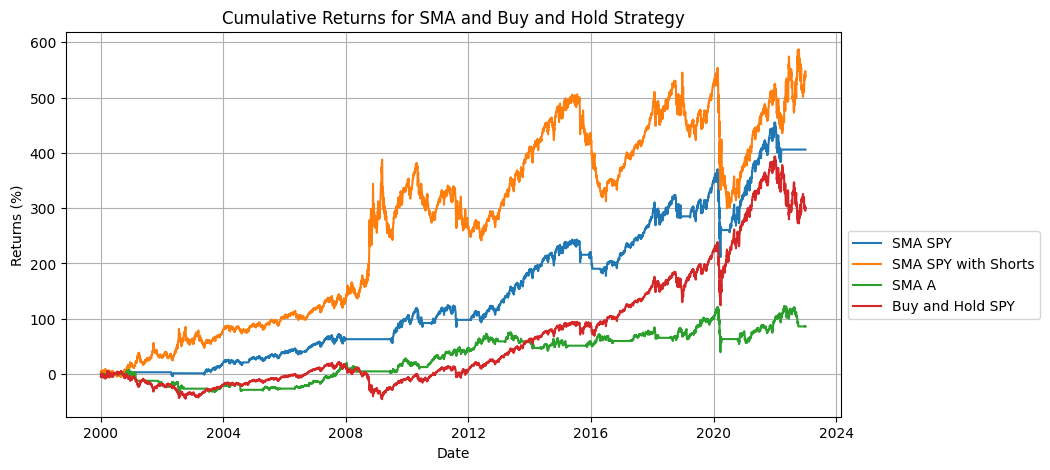

In [25]:
sma_spy_data = SMABacktest('spy', short_term_sma,
    long_term_sma, shorts=False)
sma_spy_data_shorts = SMABacktest('spy', short_term_sma,
    long_term_sma, shorts=True)
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax.plot((sma_spy_data['strat_cum_returns'] - 1) * 100,
    label='SMA SPY')
ax.plot((sma_spy_data_shorts['strat_cum_returns'] - 1) * 100,
    label='SMA SPY with Shorts')
ax.plot((data['strat_cum_returns'] - 1) * 100,
    label='SMA A')
ax.plot((sma_spy_data['cum_returns'] - 1) * 100,
    label='Buy and Hold SPY')
ax.set_ylabel('Returns (%)')
ax.set_xlabel('Date')
ax.set_title(f'Cumulative Returns for SMA and Buy and Hold Strategy')
ax.legend(bbox_to_anchor=[1, 0.5])
ax.grid()
plt.show()

In [ ]:
spy_stats = getStratStats(sma_spy_data, risk_free_rate=0.02)
spy_stats_shorts = getStratStats(sma_spy_data_shorts, risk_free_rate=0.02)
df0 = pd.DataFrame(stats_dict)
df0.columns = ['A SMA', 'A Buy and Hold']
df1 = pd.DataFrame(spy_stats)
df1.columns = ['SPY SMA', 'base_strat']
df2 = pd.DataFrame(spy_stats_shorts)
df2.columns = ['SPY SMA with Shorts', 'SPY Buy and Hold']
df = pd.concat([df0, df1, df2], axis=1)
df.drop('base_strat', axis=1, inplace=True)
df.round(3)

,A SMA,A Buy and Hold,SPY SMA,SPY SMA with Shorts,SPY Buy and Hold
tot_returns,0.863,3.238,4.060,5.380,3.013
annual_returns,0.027,0.065,0.073,0.084,0.062
annual_volatility,0.148,0.210,0.126,0.199,0.199
sharpe_ratio,0.050,0.214,0.423,0.322,0.213
max_drawdown,0.819,1.349,1.586,2.542,1.208
max_drawdown_duration,2507.000,2803.000,940.000,1695.000,2406.000
